# Red Neuronal con arquitectura optimizada basada en Random Forest


Este notebook ajusta la red neuronal basándose en los mejores hiperparámetros encontrados por Random Forest:

- `n_clusters = 56`: indica una fuerte influencia del componente geográfico.
- Profundidad alta en RF → red neuronal más profunda.
- Uso de subconjuntos de features (`max_features = sqrt`) → mayor `Dropout`.

**Objetivo**: acercarse al RMSE del modelo Random Forest (≈ 41.600$).


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import ClusterSimilarity, get_preprocessor
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cpu


In [2]:

housing = pd.read_csv("housing.csv")
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"].copy()

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [3]:

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)


In [4]:

# Reemplazamos el cluster similarity en preprocessing con 56 clusters
def get_rf_aligned_preprocessor(df):
    from sklearn.pipeline import make_pipeline
    from sklearn.compose import ColumnTransformer, make_column_selector
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
    import numpy as np

    def column_ratio(X): return X[:, [0]] / X[:, [1]]
    def ratio_name(fn, cols): return ["ratio"]
    def ratio_pipeline():
        return make_pipeline(
            SimpleImputer(strategy="median"),
            FunctionTransformer(column_ratio, feature_names_out=ratio_name),
            StandardScaler()
        )
    log_pipeline = make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(np.log, feature_names_out="one-to-one"),
        StandardScaler()
    )
    default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
    cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

    cluster_simil = make_pipeline(
        SimpleImputer(strategy="median"),
        ClusterSimilarity(n_clusters=56, gamma=1.0)  # Ajuste desde Random Forest
    )

    return ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object))
    ], remainder=default_num_pipeline)

preprocessor = get_rf_aligned_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train).astype(np.float32)
X_valid_prep = preprocessor.transform(X_valid).astype(np.float32)
X_test_prep = preprocessor.transform(X_test).astype(np.float32)

X_train_tensor = torch.tensor(X_train_prep)
y_train_tensor = torch.tensor(y_train_scaled)
X_valid_tensor = torch.tensor(X_valid_prep).to(device)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
X_test_tensor = torch.tensor(X_test_prep).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)


In [5]:

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)


In [6]:

class HousingNet(nn.Module):
    def __init__(self, input_dim):
        super(HousingNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = HousingNet(X_train_prep.shape[1]).to(device)


In [7]:

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 100
best_rmse = float('inf')
patience = 10
trigger = 0

for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_valid_tensor)
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),
            y_scaler.inverse_transform(val_outputs.cpu().numpy())
        ))

    print(f"Epoch {epoch+1}, Val RMSE: {val_rmse:.2f}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break


Epoch 1, Val RMSE: 61246.73
Epoch 2, Val RMSE: 57384.96
Epoch 3, Val RMSE: 55795.91
Epoch 4, Val RMSE: 55803.28
Epoch 5, Val RMSE: 55159.64
Epoch 6, Val RMSE: 54622.19
Epoch 7, Val RMSE: 54700.55
Epoch 8, Val RMSE: 55283.72
Epoch 9, Val RMSE: 53451.41
Epoch 10, Val RMSE: 53548.52
Epoch 11, Val RMSE: 53327.32
Epoch 12, Val RMSE: 53649.99
Epoch 13, Val RMSE: 52832.22
Epoch 14, Val RMSE: 52275.46
Epoch 15, Val RMSE: 52443.58
Epoch 16, Val RMSE: 51070.37
Epoch 17, Val RMSE: 52282.65
Epoch 18, Val RMSE: 52985.55
Epoch 19, Val RMSE: 51665.71
Epoch 20, Val RMSE: 51108.88
Epoch 21, Val RMSE: 51008.04
Epoch 22, Val RMSE: 51643.48
Epoch 23, Val RMSE: 51160.42
Epoch 24, Val RMSE: 51835.97
Epoch 25, Val RMSE: 51233.33
Epoch 26, Val RMSE: 51175.23
Epoch 27, Val RMSE: 52462.38
Epoch 28, Val RMSE: 51017.74
Epoch 29, Val RMSE: 49857.04
Epoch 30, Val RMSE: 50519.07
Epoch 31, Val RMSE: 50433.24
Epoch 32, Val RMSE: 51175.22
Epoch 33, Val RMSE: 49793.36
Epoch 34, Val RMSE: 49993.65
Epoch 35, Val RMSE: 504

✅ RMSE test: 48287.908949376586


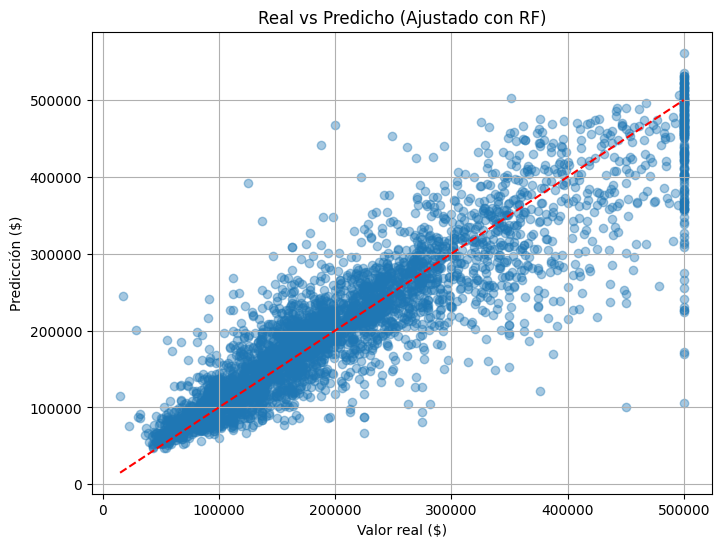

In [8]:

model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    y_test_pred_scaled = model(X_test_tensor).cpu().numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("✅ RMSE test:", rmse_test)

# Visualización
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real ($)")
plt.ylabel("Predicción ($)")
plt.title("Real vs Predicho (Ajustado con RF)")
plt.grid(True)
plt.show()
